# Predicting ride duration experiment
**source**: https://youtu.be/iRunifGSHFc?list=PL3MmuxUbc_hIUISrluw_A7wDSmfOhErJK <br>
**data taken from**: https://www.nyc.gov/site/tlc/about/tlc-trip-record-data.page <br>
**data used**: green taxi records for year 2021

In [1]:
!pip install polars

In [2]:
import polars as pl
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.feature_extraction import DictVectorizer
from sklearn.linear_model import LinearRegression, Lasso, Ridge
from sklearn.metrics import mean_squared_error
from uuid import uuid4
import pickle
from typing import Any

In [3]:

def visualize_results(y_pred, y_train):
    # Plot both on the same figure
    sns.histplot(y_pred, label="Prediction", kde=True, color="blue", stat="density")
    sns.histplot(y_train, label="Actual", kde=True, color="orange", stat="density")

    plt.legend()
    plt.title("Prediction vs Actual Distribution")
    plt.xlabel("Value")
    plt.ylabel("Density")
    plt.show()

In [4]:
def read_dataframe(filename: str):
    df = pl.read_parquet(filename)

    # Add a new column named duration which is measured in minutes
    df = df.with_columns(
        (
            (pl.col("lpep_dropoff_datetime") - pl.col("lpep_pickup_datetime"))
            .dt.total_seconds() / 60
        ).alias("duration")
    )

    # filter rides that are between 1 and 60 minutes
    df = df.filter(
        (pl.col("duration") >= 1) & (pl.col("duration") <= 60)
    )
    
    categorical = ["PULocationID", "DOLocationID"]

    df[categorical] = df[categorical].cast(pl.String)
    
    return df

In [15]:
def export_model(dict_vec: DictVectorizer, model: Any, model_name: str):
    with open(f"../models/{model_name}_{str(uuid4())[:10]}.bin", 'wb') as mf_out:
        pickle.dump((dict_vec, model), mf_out) 
    

### Load data

In [6]:
df_train = read_dataframe('../data/green_tripdata_2021-01.parquet')
df_val = read_dataframe('../data/green_tripdata_2021-02.parquet')

### Training

In [7]:
df_train = df_train.with_columns((pl.col('PULocationID') + "_" + pl.col('DOLocationID')).alias('PU_DO'))
df_val = df_train.with_columns((pl.col('PULocationID') + "_" + pl.col('DOLocationID')).alias('PU_DO'))

In [8]:
categorical = ["PU_DO"] # "DOLocationID"]
numerical = ["trip_distance"]

dv = DictVectorizer()

train_dicts = df_train[categorical + numerical].to_dicts()
X_train = dv.fit_transform(train_dicts)

val_dicts = df_val[categorical + numerical].to_dicts()
X_val = dv.transform(val_dicts)


In [9]:
target = 'duration'
y_train = df_train[target].to_numpy()
y_val = df_val[target].to_numpy()

### Linear Regression Model

In [10]:

lr_model = LinearRegression()
lr_model.fit(X_train, y_train)


y_pred = lr_model.predict(X_val)

mean_squared_error(y_val, y_pred, squared=False)  # outputs how many minutes off we are from the prediction

4.640803159048316

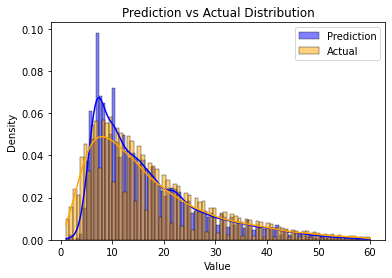

In [11]:
visualize_results(
    y_pred, y_train
)

In [16]:
export_model(dv, lr_model, "linear_regression_model")

### Lasso Model

In [ ]:
lasso_model = Lasso(alpha=0.001)
lasso_model.fit(X_train, y_train)

lasso_y_pred = lasso_model.predict(X_val)

mean_squared_error(y_val, lasso_y_pred, squared=False)  # outputs how many minutes off we are from the prediction

In [ ]:
visualize_results(
    lasso_y_pred, y_train
)